### Instalar dependencias y configurar el entorno

In [1]:
#!pip install yfinance

In [2]:
!pip install tensorflow

In [3]:
!pip install pandas-datareader

### Importar las dependencias

In [4]:
import math
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
# import pandas_datareader as data_reader
import yfinance as yf

from tqdm import tqdm_notebook, tqdm
from collections import deque

In [5]:
tf.__version__

'2.7.0'

### Construir la red neuronal de la AI del Trader

In [6]:
class AI_Trader():

  def __init__(self, state_size, action_space = 3, model_name = 'AITrader'): # Mantener, comprar, vender
    self.state_size = state_size
    self.action_space = action_space
    self.memory = deque(maxlen = 2000)
    self.inventory = []
    self.model_name = model_name

    self.gamma = 0.95
    self.epsilon = 1.0
    self.epsilon_final = 0.01
    self.epsilon_decay = 0.995
    self.model = self.model_builder()

  def model_builder(self):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(units = 32, activation = 'relu', input_dim = self.state_size))
    model.add(tf.keras.layers.Dense(units = 64, activation = 'relu'))
    model.add(tf.keras.layers.Dense(units = 128, activation = 'relu'))
    model.add(tf.keras.layers.Dense(units = self.action_space, activation = 'linear'))
    model.compile(loss = 'mse', optimizer = tf.keras.optimizers.Adam(lr = 0.001))

    return model

  # Toma el estado y devuelve la accion a llevar acabo
  def trade(self, state):
    if random.random() <= self.epsilon:
      return random.randrange(self.action_space)
    
    actions = self.model.predict(state)
    return np.argmax(actions[0])

  def batch_train(self, batch_size):
    batch = []
    for i in range(len(self.memory) - batch_size + 1, len(self.memory)):
      batch.append(self.memory[i])

    for state, action, reward, next_state, done in batch:
      reward = reward
      if not done:
        reward = reward + self.gamma * np.argmax(self.model.predict(next_state)[0]) # Bellman's equation
      
      target = self.model.predict(state)
      target[0][action] = reward

      self.model.fit(state, target, epochs = 1, verbose = 0)

    if self.epsilon > self.epsilon_final:
      self.epsilon *= self.epsilon_decay




### Pre Procesado del dataset

#### Definir las funciones adicionales

###### Sigmoide

In [7]:
sigmoid = lambda x :  1 / (1+ + math.exp(-x))

##### Función de formato de precios

In [8]:
def stocks_price_format(n):
  if n < 0:
    return '- $ {0:2f}'.format(abs(n))
  else:
    return '$ {0:2f}'.format(abs(n))
  

##### Carga del dataset

In [9]:

def dataset_loader(stock_name):
  ticker = yf.Ticker(stock_name)
  dataset = ticker.history(period = 'max')
  dataset = dataset.sort_values('Date', ascending = False)

  start_date = str(dataset.index[0]).split()[0]
  end_date = str(dataset.index[-1]).split()[0]

  close = dataset['Close']

  return close

##### State creator


In [10]:
def state_creator(data, timestep, window_size):
  starting_id = timestep - window_size + 1

  if starting_id >= 0:
    windowed_data = data[starting_id: timestep + 1]
  else:
    windowed_data = -starting_id * [data[0]] + list(data[0: timestep + 1])

  state = []
  for i in range(window_size - 1):
    state.append(sigmoid(windowed_data[i + 1] - windowed_data[i]))
  
  return np.array([state])

##### Cargar divisa de mercado

In [11]:
stock_name = 'AAPL'
data = dataset_loader(stock_name)

In [12]:
data


Date
2021-12-28    179.289993
2021-12-27    180.330002
2021-12-23    176.279999
2021-12-22    175.639999
2021-12-21    172.990005
                 ...    
1980-12-18      0.093029
1980-12-17      0.090408
1980-12-16      0.088224
1980-12-15      0.095213
1980-12-12      0.100453
Name: Close, Length: 10349, dtype: float64

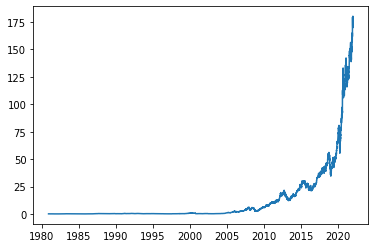

In [13]:
plt.plot(data)

### Entrenar la AI Trader

In [14]:
# Configurar loshiper parametros
window_size = 10
episodes = 1000

batch_size = 32
data_samples = len(data) - 1

In [15]:
trader = AI_Trader(window_size)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [16]:
trader.model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                352       
                                                                 
 dense_1 (Dense)             (None, 64)                2112      
                                                                 
 dense_2 (Dense)             (None, 128)               8320      
                                                                 
 dense_3 (Dense)             (None, 3)                 387       
                                                                 
Total params: 11,171
Trainable params: 11,171
Non-trainable params: 0
_________________________________________________________________


In [ ]:
for episode in range(1, episodes + 1):
  print('Episodio: {}/{}'.format(episode, episodes))
  state = state_creator(data, 0, window_size + 1)

  total_profit = 0
  trader.inventory = []

  for t in tqdm(range(data_samples)):
    action = trader.trade(state)

    next_state = state_creator(data, t + 1, window_size + 1)
    reward = 0

    if action == 1: # Compra
      trader.inventory.append(data[t])
      print('AI Trader compró: ', stocks_price_format(data[t]))

    elif action == 2 and len(trader.inventory) > 0: #Vende
      buy_price = trader.inventory.pop(0)

      reward = max(data[t] - buy_price, 0)
      total_profit += data[t] - buy_price
      print('AI Trader vendió: ', stocks_price_format(data[t]), ' Beneficio: ' + stocks_price_format(data[t] - buy_price))
    
    if t == data_samples - 1:
      done = True
    else:
      done = False
    
    trader.memory.append((state, action, reward, next_state, done))

    state = next_state

    if done:
      print('###########################')
      print('BENEFICIO TOTAL: {}'.format(total_profit))
      print('###########################')

    if len(trader.memory) > batch_size:
      trader.batch_train(batch_size)

  if episode % 10 == 0:
    trader.model.save('ai trader {}.h5'.format(episode))

Episodio: 1/1000


  0%|          | 0/10348 [00:00<?, ?it/s]

AI Trader compró:  $ 179.289993
AI Trader vendió:  $ 176.279999  Beneficio: - $ 3.009995
AI Trader compró:  $ 175.639999
AI Trader compró:  $ 172.259995
AI Trader compró:  $ 175.740005
AI Trader vendió:  $ 179.449997  Beneficio: $ 3.809998
AI Trader compró:  $ 175.080002
AI Trader vendió:  $ 171.179993  Beneficio: - $ 1.080002
AI Trader vendió:  $ 161.839996  Beneficio: - $ 13.900009
AI Trader compró:  $ 163.759995
AI Trader compró:  $ 165.300003
AI Trader compró:  $ 161.410004
AI Trader vendió:  $ 161.020004  Beneficio: - $ 14.059998
AI Trader compró:  $ 157.869995
AI Trader compró:  $ 147.869995


  0%|          | 33/10348 [00:15<1:20:33,  2.13it/s]

AI Trader vendió:  $ 150.809998  Beneficio: - $ 12.949997


  0%|          | 36/10348 [00:29<3:21:23,  1.17s/it]

AI Trader compró:  $ 150.740005


  0%|          | 37/10348 [00:34<4:20:07,  1.51s/it]

AI Trader compró:  $ 151.269241


  0%|          | 38/10348 [00:39<5:27:06,  1.90s/it]

AI Trader vendió:  $ 149.801376  Beneficio: - $ 15.498627


  0%|          | 39/10348 [00:44<6:40:41,  2.33s/it]

AI Trader compró:  $ 148.742920


  0%|          | 41/10348 [00:54<9:13:49,  3.22s/it]

AI Trader compró:  $ 152.347656


  0%|          | 42/10348 [00:59<10:15:28,  3.58s/it]

AI Trader vendió:  $ 148.633087  Beneficio: - $ 12.776917


  0%|          | 43/10348 [01:03<11:08:10,  3.89s/it]

AI Trader compró:  $ 149.102402


  0%|          | 44/10348 [01:08<11:48:39,  4.13s/it]

AI Trader vendió:  $ 148.423386  Beneficio: - $ 9.446609


  0%|          | 45/10348 [01:13<12:21:19,  4.32s/it]

AI Trader vendió:  $ 148.473312  Beneficio: $ 0.603317


  0%|          | 47/10348 [01:23<13:11:38,  4.61s/it]

AI Trader compró:  $ 149.042480


  0%|          | 48/10348 [01:28<13:24:13,  4.68s/it]

AI Trader compró:  $ 148.543198


  0%|          | 49/10348 [01:33<13:34:38,  4.75s/it]

AI Trader compró:  $ 146.336426


  0%|          | 51/10348 [01:44<14:48:26,  5.18s/it]

AI Trader vendió:  $ 143.550491  Beneficio: - $ 7.189514


  1%|          | 54/10348 [02:00<14:59:08,  5.24s/it]

AI Trader compró:  $ 142.601883


  1%|          | 55/10348 [02:05<15:08:11,  5.29s/it]

AI Trader compró:  $ 142.691742


  1%|          | 57/10348 [02:15<14:25:44,  5.05s/it]

AI Trader compró:  $ 141.793060


  1%|          | 58/10348 [02:20<14:20:55,  5.02s/it]

AI Trader vendió:  $ 140.904358  Beneficio: - $ 10.364883


  1%|          | 62/10348 [02:39<13:56:43,  4.88s/it]

AI Trader compró:  $ 142.621857


  1%|          | 64/10348 [02:49<13:54:21,  4.87s/it]

AI Trader vendió:  $ 145.158142  Beneficio: - $ 3.584778


  1%|          | 66/10348 [02:59<14:07:08,  4.94s/it]

AI Trader compró:  $ 146.616028


  1%|          | 70/10348 [03:18<13:53:20,  4.86s/it]

AI Trader compró:  $ 145.847137


  1%|          | 71/10348 [03:23<14:05:07,  4.93s/it]

AI Trader compró:  $ 148.573151


  1%|          | 72/10348 [03:28<13:59:39,  4.90s/it]

AI Trader compró:  $ 148.812805


  1%|          | 73/10348 [03:33<13:58:00,  4.89s/it]

AI Trader vendió:  $ 147.904129  Beneficio: - $ 4.443527


  1%|          | 74/10348 [03:38<13:55:53,  4.88s/it]

AI Trader vendió:  $ 149.332062  Beneficio: $ 0.229660


  1%|          | 75/10348 [03:43<13:51:13,  4.85s/it]

AI Trader compró:  $ 148.752899


  1%|          | 77/10348 [03:53<14:04:45,  4.93s/it]

AI Trader compró:  $ 154.883957


  1%|          | 78/10348 [03:58<14:00:10,  4.91s/it]

AI Trader compró:  $ 156.461655


  1%|          | 79/10348 [04:02<13:59:04,  4.90s/it]

AI Trader vendió:  $ 154.075134  Beneficio: $ 5.032654


  1%|          | 80/10348 [04:07<13:59:13,  4.90s/it]

AI Trader compró:  $ 153.426071


  1%|          | 82/10348 [04:17<13:57:11,  4.89s/it]

AI Trader vendió:  $ 151.608734  Beneficio: $ 3.065536


  1%|          | 83/10348 [04:22<13:51:27,  4.86s/it]

AI Trader compró:  $ 152.896851


  1%|          | 85/10348 [04:32<13:57:32,  4.90s/it]

AI Trader compró:  $ 147.324982


  1%|          | 86/10348 [04:37<13:56:34,  4.89s/it]

AI Trader compró:  $ 148.143784


  1%|          | 87/10348 [04:42<13:55:37,  4.89s/it]

AI Trader vendió:  $ 149.401947  Beneficio: $ 3.065521


  1%|          | 89/10348 [04:51<13:48:35,  4.85s/it]

AI Trader compró:  $ 147.974045


  1%|          | 92/10348 [05:06<13:52:44,  4.87s/it]

AI Trader compró:  $ 149.971130


  1%|          | 93/10348 [05:11<13:50:49,  4.86s/it]

AI Trader compró:  $ 150.899765


  1%|          | 94/10348 [05:16<13:48:17,  4.85s/it]

AI Trader compró:  $ 148.882721


  1%|          | 95/10348 [05:20<13:45:01,  4.83s/it]

AI Trader compró:  $ 148.673019


  1%|          | 96/10348 [05:25<13:59:45,  4.91s/it]

AI Trader vendió:  $ 145.647430  Beneficio: $ 3.045547


  1%|          | 97/10348 [05:30<13:52:48,  4.87s/it]

AI Trader compró:  $ 145.387817


  1%|          | 98/10348 [05:35<13:55:40,  4.89s/it]

AI Trader vendió:  $ 145.877090  Beneficio: $ 3.185349


  1%|          | 100/10348 [05:45<13:50:06,  4.86s/it]

AI Trader vendió:  $ 146.626007  Beneficio: $ 4.832947


  1%|          | 101/10348 [05:50<13:47:34,  4.85s/it]

AI Trader vendió:  $ 146.516327  Beneficio: $ 3.894470


  1%|          | 102/10348 [05:55<14:02:11,  4.93s/it]

AI Trader vendió:  $ 146.925110  Beneficio: $ 0.309082


  1%|          | 103/10348 [06:00<13:57:12,  4.90s/it]

AI Trader vendió:  $ 145.090546  Beneficio: - $ 0.756592


  1%|          | 104/10348 [06:04<13:51:07,  4.87s/it]

AI Trader vendió:  $ 145.429535  Beneficio: - $ 3.143616


  1%|          | 106/10348 [06:14<13:48:48,  4.86s/it]

AI Trader vendió:  $ 144.552139  Beneficio: - $ 4.260666


  1%|          | 107/10348 [06:19<13:51:37,  4.87s/it]

AI Trader compró:  $ 146.336853


  1%|          | 109/10348 [06:29<13:56:40,  4.90s/it]

AI Trader compró:  $ 148.121582


  1%|          | 110/10348 [06:34<13:55:30,  4.90s/it]

AI Trader vendió:  $ 146.366760  Beneficio: - $ 2.386139


  1%|          | 111/10348 [06:39<13:56:33,  4.90s/it]

AI Trader vendió:  $ 144.970901  Beneficio: - $ 9.913055


  1%|          | 112/10348 [06:44<13:57:18,  4.91s/it]

AI Trader compró:  $ 145.718674


  1%|          | 114/10348 [06:53<13:52:18,  4.88s/it]

AI Trader compró:  $ 145.957977


  1%|          | 115/10348 [06:58<14:05:10,  4.96s/it]

AI Trader vendió:  $ 148.041809  Beneficio: - $ 8.419846


  1%|          | 117/10348 [07:08<14:02:06,  4.94s/it]

AI Trader compró:  $ 145.210190


  1%|          | 118/10348 [07:13<13:59:10,  4.92s/it]

AI Trader compró:  $ 144.073563


  1%|          | 119/10348 [07:18<13:59:04,  4.92s/it]

AI Trader vendió:  $ 144.681763  Beneficio: - $ 8.744308


  1%|          | 120/10348 [07:23<13:59:16,  4.92s/it]

AI Trader vendió:  $ 142.817276  Beneficio: - $ 10.079575


  1%|          | 121/10348 [07:28<14:07:50,  4.97s/it]

AI Trader vendió:  $ 144.143356  Beneficio: - $ 3.181625


  1%|          | 122/10348 [07:33<13:59:55,  4.93s/it]

AI Trader compró:  $ 141.600876


  1%|          | 124/10348 [07:43<13:54:02,  4.89s/it]

AI Trader vendió:  $ 136.864899  Beneficio: - $ 11.278885


  1%|          | 126/10348 [07:52<13:51:07,  4.88s/it]

AI Trader vendió:  $ 135.927673  Beneficio: - $ 12.046371


  1%|          | 127/10348 [07:57<14:01:44,  4.94s/it]

AI Trader vendió:  $ 134.382248  Beneficio: - $ 15.588882


  1%|          | 128/10348 [08:02<13:59:31,  4.93s/it]

AI Trader compró:  $ 132.717178
